<div class="alert alert-block alert-danger">  
    <h2><strong>Working notebook to the article:</strong></h2>
    <h1><strong>"Bioenergetic model of retrotransposon activity in cancer cells" (Life, 2025)</strong></h1>
<strong>Authors: Sergey Pavlov, Maria Duk, Vitaly V. Gursky, Maria Samsonova, Alexander Kanapin, and Anastasia Samsonova</strong> <br>
<strong>Funding: This research was funded by the Russian Science Foundation, grant No. 23–24–00153.</strong> <br>

</div>

# Import requred libruaries and set notebook settings

In [6]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import copy as cp
from math import *
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
# from pylab import rcParams
import seaborn as sns
#
import scipy
import scipy.integrate as integrate
from scipy.optimize import root
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

In [3]:
# Check python version, system parameters and packages versions:
from watermark import watermark
print(watermark())
print(watermark(packages="numpy,pandas,tqdm,matplotlib,seaborn,scipy"))

Last updated: 2025-03-13T22:16:13.884472+03:00

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.17.2

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 191 Stepping 2, GenuineIntel
CPU cores   : 16
Architecture: 64bit

numpy     : 1.26.1
pandas    : 2.1.3
tqdm      : 4.66.1
matplotlib: 3.8.1
seaborn   : 0.13.0
scipy     : 1.11.3



In [4]:
# write list to binary file
def write2pickle(file, fname):
    # store list in binary file so 'wb' mode
    with open(fname, 'wb') as f:
        pickle.dump(file, f)
        print('Done writing list into a binary file')

# Read list to memory
def read_pickle(fname):
    # for reading also binary mode is important
    with open(fname, 'rb') as f:
        file = pd.read_pickle(f)
        return file

# Chech directories exit. Create if not
def check_dir_exist(path):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

In [7]:
# This is to enable inline displays
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Plot parameters
mpl.rcParams['figure.figsize'] = 6,4
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams["figure.autolayout"] = True
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300

# Seaborn settings for notebook
rc = {'lines.linewidth': 1.,
      'axes.titlesize': 14,
      'axes.labelsize': 14,
      'xtick.labelsize': 10,
      'ytick.labelsize': 10,
      'legend.fontsize': 10,
      'savefig.dpi': 300,
      'axes.facecolor': 'white'}
sns.set_context('notebook', rc=rc)
sns.set_style('ticks', rc=rc)

In [8]:
# Set colors
colormap = ['magenta',
           'darkcyan',
           'darkseagreen',
           'green',
           'royalblue',
           'orangered',
           'steelblue',
           'peru',
           'skyblue',
           'firebrick',
           'blue',
           'red']

# Reference Stationary Solution 

Set values of variables in reference stationary solution

In [9]:
# expected observables under normal conditions:
a0,mq0,cq0,q0,mL0,mS0,cL0,O10,bL0,bS0,L0,S0 = np.array([5.32028879e+09, 5.43892043e+06, 2.60750605e+06, 3.20098867e+09,
                                                        5.13241818e+04, 1.21841508e+08, 1.07775213e+05, 2.78154330e+07,
                                                        2.82625278e+03, 5.64255248e+03, 1.06716935e+03, 1.33614820e+04])

# Steady state reference
sty0 = np.array([a0,mq0,cq0,q0,mL0,mS0,cL0,O10,bL0,bS0,L0,S0])

# changable parameters
A0       = 1.31e10 # energy supply [m.p.c./min]
lmd_a    = 1.47    # ATP molecules degradation rate constant [1/min]
lmd_L    = 0.37    # LINE-1 deactivation rate constant [1/min]
lmd_S    = 1.18    # SINE deactivation rate constant [1/min]

In [11]:
# Set directories
path = "./data/"
dir_save = path+"save/"
dir_pic = path+"pic/"
dir_svg = dir_pic+"svg/"

# Set: save plots or not
save_pic = False
save_svg = False

# chech directories exit, create if not
check_dir_exist(dir_save)
check_dir_exist(dir_pic)
check_dir_exist(dir_svg)

# Set the model

In [29]:
# Wild type values
awt = 5.33e9  # characteristic number of ATP
Lwt = 1064.   # number of LINE-1 in wild type
Swt = 13243.  # number of SINE in wild type

### Constants: ###
Ng       = 3.08e9  # total genome size [bp]
Q        = 3804.   # number of housekeeping genes
nq       = 431.    # median HeLa cell protein length [aa]
nQ       = 1300.   # median HeLa housekeeping gene length [bp]
nL       = 6000.   # LINE-1 length [bp]
nS       = 300.    # SINE length [bp]
Naa      = 5.      # number of ATP molecules for adding a.a. [m.p.c. - mol. per cell]
Nnt      = 15.     # number of ATP molecules for adding nt. [m.p.c.]
tdiv     = 22.*60  # HeLa cell cycle duration, in minutes [min] ( == 1320 min )

### Parameter values: ###
rtot     = 9.5e6   # total number of ribosomes [m.p.c.]
Xi_max_L = 840.    # maximal integration elongation rate of one LINE-1 transposon [bp/(m.p.c.*min)]
Xi_max_S = 840.    # maximal integration elongation rate of one SINE transposon [bp/(m.p.c.*min)]
K_Xi_L   = 1.1e7   # integration elongation threshold of LINE-1 transposons [m.p.c.]
K_Xi_S   = 1.1e7   # integration elongation threshold of SINE transposons [m.p.c.]
KL       = 2.24e-3 # association constant of LINE-1 mRNA with ORF1p [1/m.p.c.]
wq       = 4.64    # maximal transcription rate of one gene [m.p.c./min]
wL       = 1.      # maximal transcription rate of one LINE-1 [m.p.c./min]
wS       = 20.     # maximal transcription rate of one SINE [m.p.c./min]
Th_nr_q  = 3.8e9   # transcription threshold of one gene [m.p.c.]
Th_nr_L  = 3.8e9   # transcription threshold of one LINE-1 [m.p.c.]
Th_nr_S  = 3.8e9   # transcription threshold of one SINE [m.p.c.]
gm_max_q = 300.    # maximal translation rate of q-RNA (aa/min) [a.a./(m.p.c.*min)]
gm_max_L = 300.    # maximal translation rate of LINE-1 RNA (aa/min) [a.a./(m.p.c.*min)]
K_gm_q   = 25900.  # translation threshold of one q-RNA [m.p.c.]
K_gm_L   = 25900.  # translation threshold of one LINE-1 RNA [m.p.c.]
k_bq     = 5e-8    # 2.7e-2 # cq complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_bL     = 5e-8    # 2.7e-2 # cL complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_uq     = 1e-2    # 1e3 # cq complexes unbinding rate constant
k_uL     = 1e-2    # 1e3 # cL complexes unbinding rate constant
k_subS   = 5e-8    # 6e-8 # bS formation (ORFp2+mS) substitution of mL
k_subL   = 5e-6    # 6e-8 # bL formation (ORFp2+mL) substitution of mS
d_mq     = 1.15e-3 # q-RNAs degradation rate constant [1/min]
d_cq     = 1.55e-3 # cq complexes degradation rate constant [1/min]
d_q      = 5.67e-4 # q proteins degradation rate constant [1/min]
d_mL     = 1.15e-3 # LINE-1 RNAs degradation rate constant [1/min]
d_mS     = 1.15e-3 # ! # SINE RNAs degradation rate constant [1/min]
d_cL     = 1.55e-3 # cL complexes degradation rate constant [1/min]
d_O1     = 5.67e-4 # ORF1p degradation rate constant [1/min]
d_bL     = 5.67e-4 # bL complexes degradation rate constant [1/min]
d_bS     = 5.67e-4 # bS complexes degradation rate constant [1/min]

# Add some
rib = rtot - cq0 - cL0 # number of free ribosomes
vrepl_max = Nnt*(Ng/tdiv)/0.8
k_vrepl = 0.25*a0

In [30]:
# Set dictionary with parameter names (for plotting)
par_dict_names = {
    "Ng"       : '$N_g$',
    "Q"        : '$Q$',    
    "nq"       : '$n_q$',
    "nQ"       : '$n_Q$',
    "nL"       : '$n_L$',
    "nS"       : '$n_S$',
    "Naa"      : '$N_{aa}$',
    "Nnt"      : '$N_{nt}$',
    "tdiv"      : r'$\tau$',
    #
    "rtot"     : '$r_{tot}$',
    "Xi_max_L" : r'$\chi_{maxL}$',
    "Xi_max_S" : r'$\chi_{maxS}$',
    "K_Xi_L"   : r'$K_{\chi L}$',
    "K_Xi_S"   : r'$K_{\chi S}$',
    "KL"       : '$K_L$',
    "wq"       : r'$w_q$',
    "wL"       : r'$w_L$',
    "wS"       : r'$w_S$',
    "Th_nr_q"  : r'$\theta_q$',
    "Th_nr_L"  : r'$\theta_L$',
    "Th_nr_S"  : r'$\theta_S$',
    "gm_max_q" : r'$\gamma_{maxq}$',
    "gm_max_L" : r'$\gamma_{maxL}$',
    "K_gm_q"   : r'$K_{\gamma q}$',
    "K_gm_L"   : r'$K_{\gamma L}$',
    "k_bq"     : '$k_{bq}$',
    "k_bL"     : '$k_{bL}$',
    "k_uq"     : '$k_{uq}$',
    "k_uL"     : '$k_{uL}$',
    "k_subS"   : '$k_{subS}$',
    "k_subL"   : '$k_{subL}$',
    "d_mq"     : '$d_{mq}$',
    "d_cq"     : '$d_{cq}$',
    "d_q"      : '$d_{q}$',
    "d_mL"     : '$d_{mL}$',
    "d_mS"     : '$d_{mS}$',
    "d_cL"     : '$d_{cL}$',
    "d_O1"     : '$d_{O1}$',
    "d_bL"     : '$d_{bL}$',
    "d_bS"     : '$d_{bS}$',
    # changable
    "A0"       : '$A_0$',
    "lmd_a"    : r'$\lambda_a$',
    "lmd_L"    : r'$\lambda_L$',
    "lmd_S"    : r'$\lambda_S$'
}

In [31]:
# Set dictionary with parameters (in order)
pdict = {
    "A0"       : 0,
    "Xi_max_L" : 1,
    "Xi_max_S" : 2,
    "K_Xi_L"   : 3,
    "K_Xi_S"   : 4,
    "KL"       : 5,
    "wq"       : 6,
    "wL"       : 7,
    "wS"       : 8,
    "Th_nr_q"  : 9,
    "Th_nr_L"  : 10,
    "Th_nr_S"  : 11,
    "gm_max_q" : 12,
    "gm_max_L" : 13,
    "K_gm_q"   : 14,
    "K_gm_L"   : 15,
    "k_bq"     : 16,
    "k_bL"     : 17,
    "k_uq"     : 18,
    "k_uL"     : 19,
    "k_subS"   : 20,
    "k_subL"   : 21,
    "rtot"     : 22,
    "lmd_a"    : 23,
    "d_mq"     : 24,
    "d_cq"     : 25,
    "d_q"      : 26,
    "d_mL"     : 27,
    "d_mS"     : 28,
    "d_cL"     : 29,
    "d_O1"     : 30,
    "d_bL"     : 31,
    "d_bS"     : 32,
    "lmd_L"    : 33,
    "lmd_S"    : 34
}

In [32]:
# Set list with parameters (in order)
par_list = [A0      ,
            Xi_max_L,
            Xi_max_S,
            K_Xi_L  ,
            K_Xi_S  ,
            KL      ,
            wq      ,
            wL      ,
            wS      ,
            Th_nr_q ,
            Th_nr_L ,
            Th_nr_S ,
            gm_max_q,
            gm_max_L,
            K_gm_q  ,
            K_gm_L  ,
            k_bq    ,
            k_bL    ,
            k_uq    ,
            k_uL    ,
            k_subS  ,
            k_subL  ,
            rtot    ,
            lmd_a   ,
            d_mq    ,
            d_cq    ,
            d_q     ,
            d_mL    ,
            d_mS    ,
            d_cL    ,
            d_O1    ,
            d_bL    ,
            d_bS    ,
            lmd_L   ,
            lmd_S]

# to numpy & copy
npar_list = np.array(par_list, dtype='float64')
nplist = npar_list.copy()
nplist

array([1.31e+10, 8.40e+02, 8.40e+02, 1.10e+07, 1.10e+07, 2.24e-03,
       4.64e+00, 1.00e+00, 2.00e+01, 3.80e+09, 3.80e+09, 3.80e+09,
       3.00e+02, 3.00e+02, 2.59e+04, 2.59e+04, 5.00e-08, 5.00e-08,
       1.00e-02, 1.00e-02, 5.00e-08, 5.00e-06, 9.50e+06, 1.47e+00,
       1.15e-03, 1.55e-03, 5.67e-04, 1.15e-03, 1.15e-03, 1.55e-03,
       5.67e-04, 5.67e-04, 5.67e-04, 3.70e-01, 1.18e+00])

In [33]:
# translation rates:
def vq(cq_, a_):
    return gm_max_q/nq*cq_*a_/(K_gm_q+a_)

def vL(cL_,a_):
    return gm_max_L/(nL/3)*cL_*a_/(K_gm_L+a_)

# integration rates:
def vintL(bL_,O1_,a_):
    return Xi_max_L/nL * bL_*a_/(K_Xi_L+a_)*KL*O1_/(1+KL*O1_)

def vintS(bS_,a_):
    return Xi_max_S/nS * bS_*a_/(K_Xi_S+a_)

# transcription rates:
def om_q(a_):
    return Q*wq*a_/(Th_nr_q+a_)

def om_L(L_,a_):
    return L_*wL*a_/(Th_nr_L+a_)

def om_S(S_,a_):
    return S_*wS*a_/(Th_nr_S+a_)

# replication:
def vreplf(a_,bL_,O1_,bS_):
    return Nnt*(Ng/tdiv + vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS)

# ribosomes:
def ribf(cq_,cL_):
    return rtot-cq_-cL_

# Parameter-sensitive functions

In [34]:
# Function for integration
def integr_syst_par(t, y):
    A0       = nplist[0]
    Xi_max_L = nplist[1]
    Xi_max_S = nplist[2]
    K_Xi_L   = nplist[3]
    K_Xi_S   = nplist[4]
    KL       = nplist[5]
    wq       = nplist[6]
    wL       = nplist[7]
    wS       = nplist[8]
    Th_nr_q  = nplist[9]
    Th_nr_L  = nplist[10]
    Th_nr_S  = nplist[11]
    gm_max_q = nplist[12]
    gm_max_L = nplist[13]
    K_gm_q   = nplist[14]
    K_gm_L   = nplist[15]
    k_bq     = nplist[16]
    k_bL     = nplist[17]
    k_uq     = nplist[18]
    k_uL     = nplist[19]
    k_subS   = nplist[20]
    k_subL   = nplist[21]
    rtot     = nplist[22]
    lmd_a    = nplist[23]
    d_mq     = nplist[24]
    d_cq     = nplist[25]
    d_q      = nplist[26]
    d_mL     = nplist[27]
    d_mS     = nplist[28]
    d_cL     = nplist[29]
    d_O1     = nplist[30]
    d_bL     = nplist[31]
    d_bS     = nplist[32]
    lmd_L    = nplist[33]
    lmd_S    = nplist[34]
    
    # translation rates:
    def vq(cq_, a_):
        return gm_max_q/nq*cq_*a_/(K_gm_q+a_)
    
    def vL(cL_,a_):
        return gm_max_L/(nL/3)*cL_*a_/(K_gm_L+a_)
    
    # integration rates:
    def vintL(bL_,O1_,a_):
        return Xi_max_L/nL * bL_*a_/(K_Xi_L+a_)*KL*O1_/(1+KL*O1_)
    
    def vintS(bS_,a_):
        return Xi_max_S/nS * bS_*a_/(K_Xi_S+a_)
    
    # transcription rates:
    def om_q(a_):
        return Q*wq*a_/(Th_nr_q+a_)
    
    def om_L(L_,a_):
        return L_*wL*a_/(Th_nr_L+a_)
    
    def om_S(S_,a_):
        return S_*wS*a_/(Th_nr_S+a_)
    
    # replication:
    def vreplf(a_,bL_,O1_,bS_):
        return Nnt*(Ng/tdiv + vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS)
    
    # ribosomes:
    def ribf(cq_,cL_):
        return rtot-cq_-cL_
        
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y
    dydt = np.array([A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
                   - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
                   - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
                   - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
                    om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_  - d_mq*mq_, # dmq/dt
                    k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
                    vq(cq_,a_) - d_q*q_, # dq/dt
                    om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
                    om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
                    k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
                    vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
                    k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
                    vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
                    vintS(bS_,a_) - lmd_S*S_]) # dS/dt
    return dydt

In [35]:
# Function for integration
def solve_syst_par(y):
    A0       = nplist[0]
    Xi_max_L = nplist[1]
    Xi_max_S = nplist[2]
    K_Xi_L   = nplist[3]
    K_Xi_S   = nplist[4]
    KL       = nplist[5]
    wq       = nplist[6]
    wL       = nplist[7]
    wS       = nplist[8]
    Th_nr_q  = nplist[9]
    Th_nr_L  = nplist[10]
    Th_nr_S  = nplist[11]
    gm_max_q = nplist[12]
    gm_max_L = nplist[13]
    K_gm_q   = nplist[14]
    K_gm_L   = nplist[15]
    k_bq     = nplist[16]
    k_bL     = nplist[17]
    k_uq     = nplist[18]
    k_uL     = nplist[19]
    k_subS   = nplist[20]
    k_subL   = nplist[21]
    rtot     = nplist[22]
    lmd_a    = nplist[23]
    d_mq     = nplist[24]
    d_cq     = nplist[25]
    d_q      = nplist[26]
    d_mL     = nplist[27]
    d_mS     = nplist[28]
    d_cL     = nplist[29]
    d_O1     = nplist[30]
    d_bL     = nplist[31]
    d_bS     = nplist[32]
    lmd_L    = nplist[33]
    lmd_S    = nplist[34]
    
    # translation rates:
    def vq(cq_, a_):
        return gm_max_q/nq*cq_*a_/(K_gm_q+a_)
    
    def vL(cL_,a_):
        return gm_max_L/(nL/3)*cL_*a_/(K_gm_L+a_)
    
    # integration rates:
    def vintL(bL_,O1_,a_):
        return Xi_max_L/nL * bL_*a_/(K_Xi_L+a_)*KL*O1_/(1+KL*O1_)
    
    def vintS(bS_,a_):
        return Xi_max_S/nS * bS_*a_/(K_Xi_S+a_)
    
    # transcription rates:
    def om_q(a_):
        return Q*wq*a_/(Th_nr_q+a_)
    
    def om_L(L_,a_):
        return L_*wL*a_/(Th_nr_L+a_)
    
    def om_S(S_,a_):
        return S_*wS*a_/(Th_nr_S+a_)

    # replication:
    def vreplf(a_,bL_,O1_,bS_):
        return Nnt*(Ng/tdiv + vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS)
    
    # ribosomes:
    def ribf(cq_,cL_):
        return rtot-cq_-cL_
        
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y
    dydt = np.array([A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
                   - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
                   - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
                   - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
                    om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_  - d_mq*mq_, # dmq/dt
                    k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
                    vq(cq_,a_) - d_q*q_, # dq/dt
                    om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
                    om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
                    k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
                    vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
                    k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
                    vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
                    vintS(bS_,a_) - lmd_S*S_]) # dS/dt
    return dydt

<div class="alert alert-block alert-info"> 
    <h1><strong>Calculations</strong></h1>
</div>

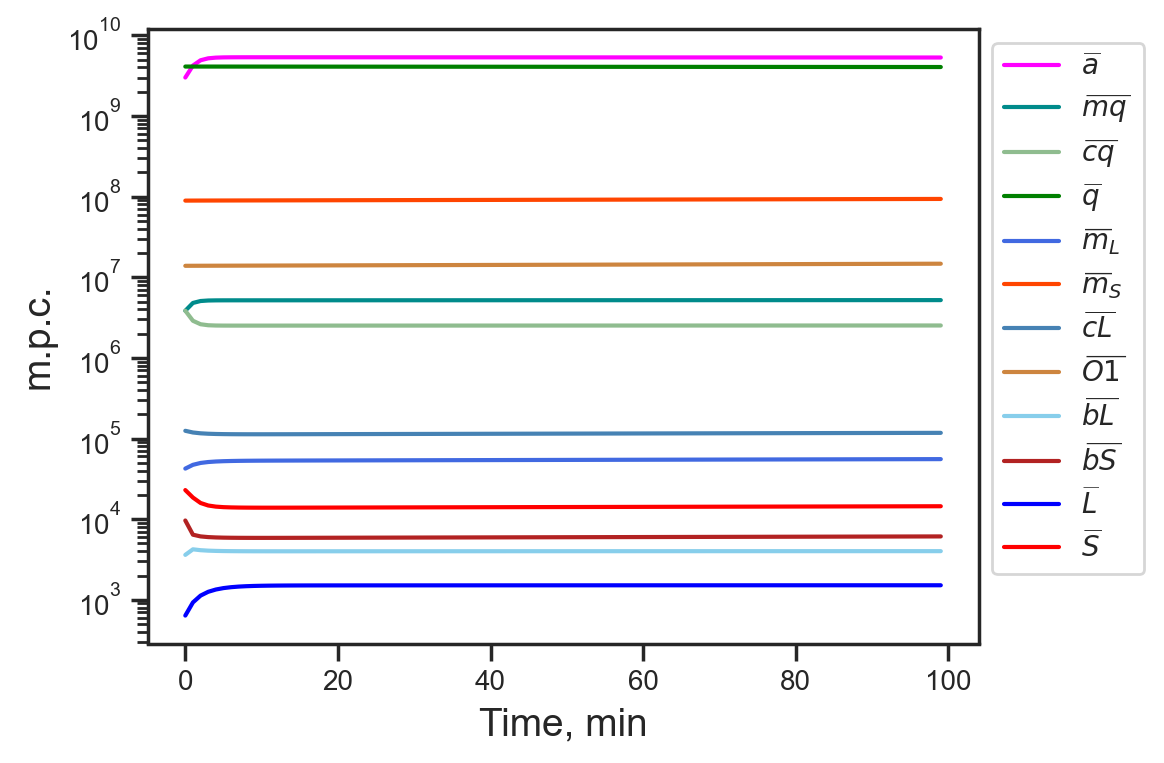

In [80]:
# Check with reference solution
t_start = 0.
t_finish = 500.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = 100 #int((t_finish-t_start)/step)

### set initial conditions
nplist = npar_list.copy()
incond = root0.x.copy()

### add white noise
seed = 12345
rng = np.random.default_rng(seed)
rfloat = rng.random(12)
incond += incond*(rfloat*2-1)*0.8

# ### Perturbe some variables
# incond[-2:] *= 10

# integrate
sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method='Radau')

# Plot reference
fig, ax = plt.subplots()

ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")

# Set axes
# ax.set_title('Dynamics')
ax.set_xlabel('Time, min')
ax.set_ylabel('m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()
plt.show()

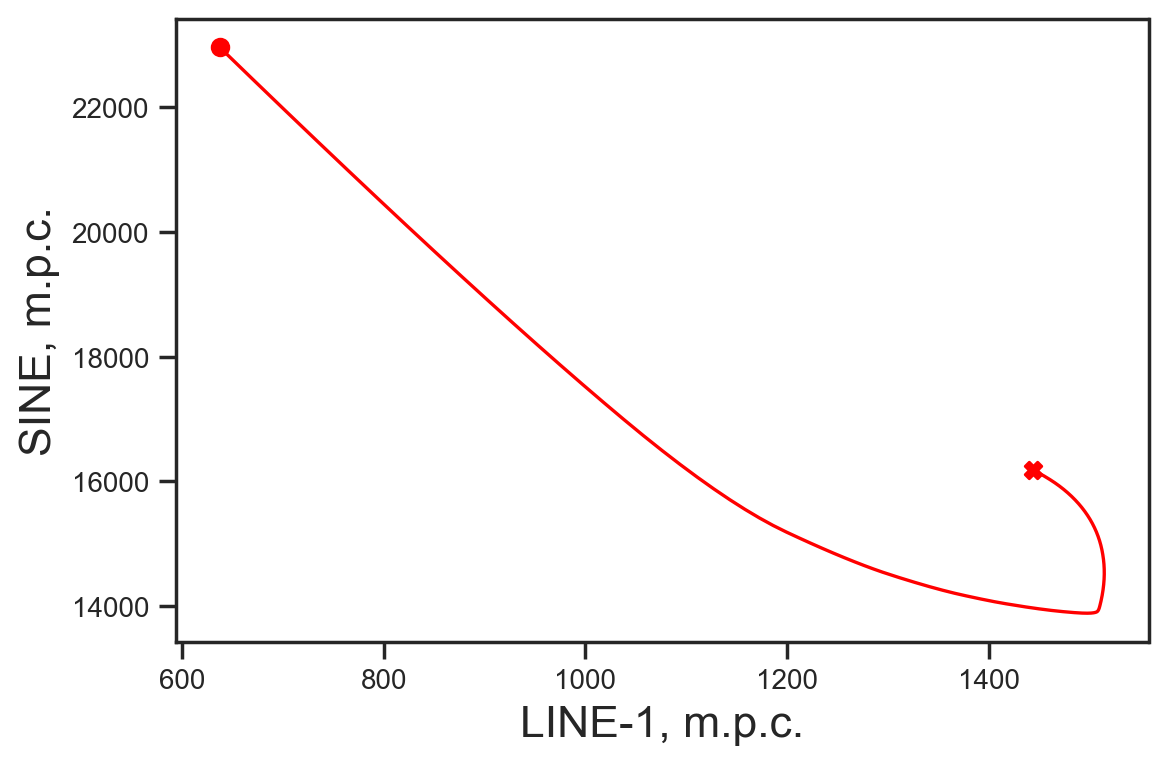

In [81]:
# Set limit
n = int((t_finish-t_start)/step)

# Interpolate
fL = interp1d(sol.t[:n], sol.y[-2,:n], kind='quadratic')
times = np.arange(sol.t[:n].min(), sol.t[:n].max(), 0.1)
yL = fL(times)
fS = interp1d(sol.t[:n], sol.y[-1,:n], kind='quadratic')
yS = fS(times)

# PLot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(yL, yS, '-', lw=1.2, color='red')
ax.scatter(yL[0], yS[0], marker='o', color='red')    
ax.scatter(yL[-1], yS[-1], marker='X', color='red')
#ax.scatter(root0.x[-2], root0.x[-1], marker='X', color='blue')

# Set axes
ax.set_xlabel('LINE-1, m.p.c.', fontsize=16)
ax.set_ylabel('SINE, m.p.c.', fontsize=16)
ax.axis('auto')
plt.tight_layout()

# save figure
dir_pic_tmp = dir_pic+"mutual/"
check_dir_exist(dir_pic_tmp)
check_dir_exist(dir_pic_tmp+"svg/")
fig_name = f"mut_LS_seed_{seed}"
if save_pic: plt.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
if save_svg: plt.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

## Multiple integrations

In [82]:
# Check with reference solution
t_start = 0.
t_finish = 50000.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)

# integrate in loop with random perturbations of initial conditions
nplist = npar_list.copy()
sols = []
for i in tqdm(range(10)):
    ### incond
    rng = np.random.default_rng(i)
    rfloat = rng.random(12)
    incond = root0.x.copy()
    incond += incond*(rfloat*2-1)*0.8
    
    # integration
    sol = integrate.solve_ivp(integr_syst_par, t_span, incond, t_eval=t, dense_output=True, method = 'Radau')
    sols.append(sol)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.96it/s]


plot: 0


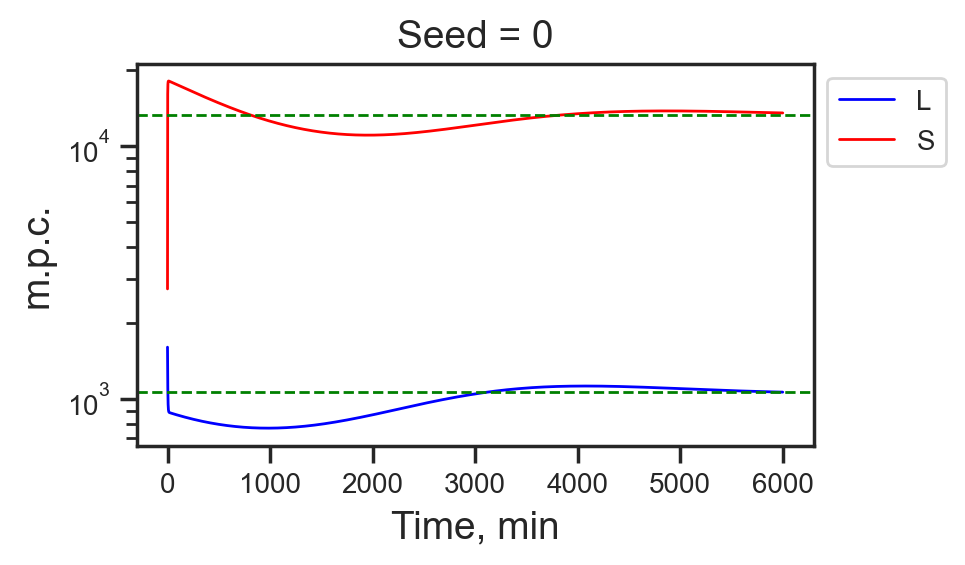

plot: 1


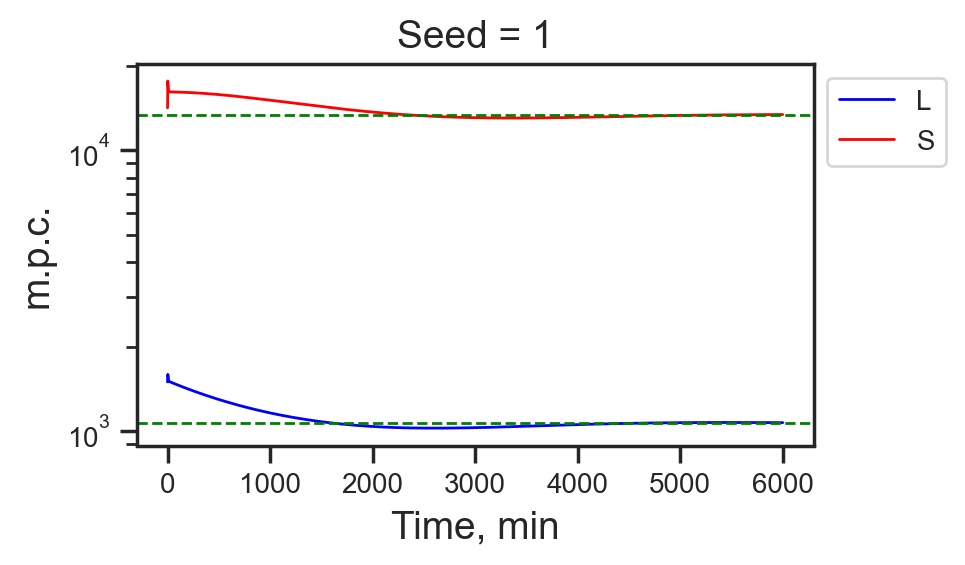

plot: 2


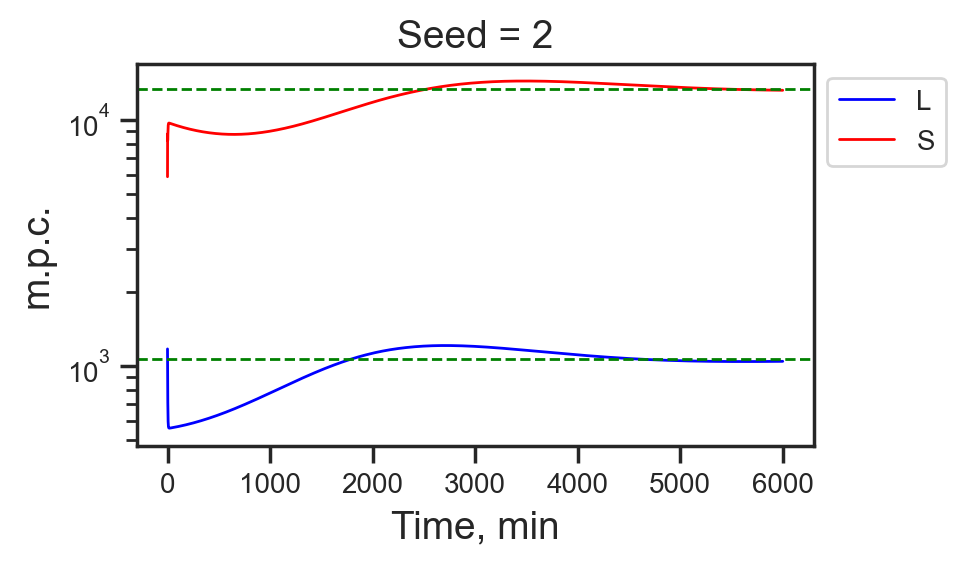

plot: 3


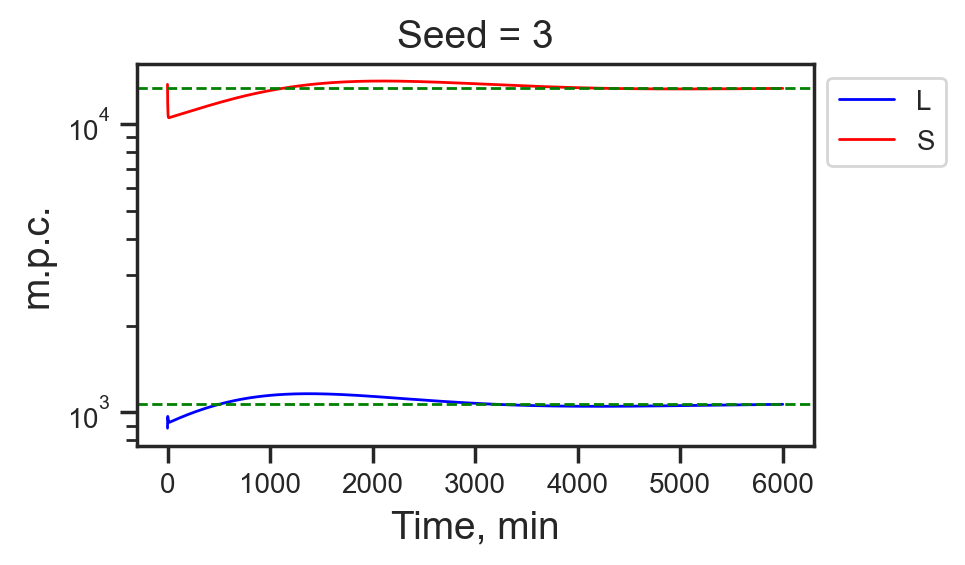

plot: 4


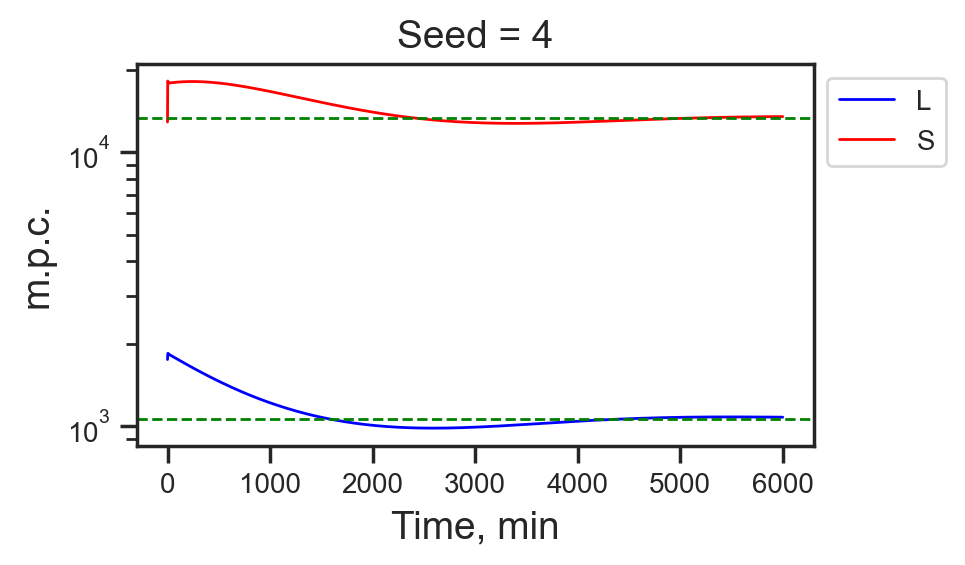

plot: 5


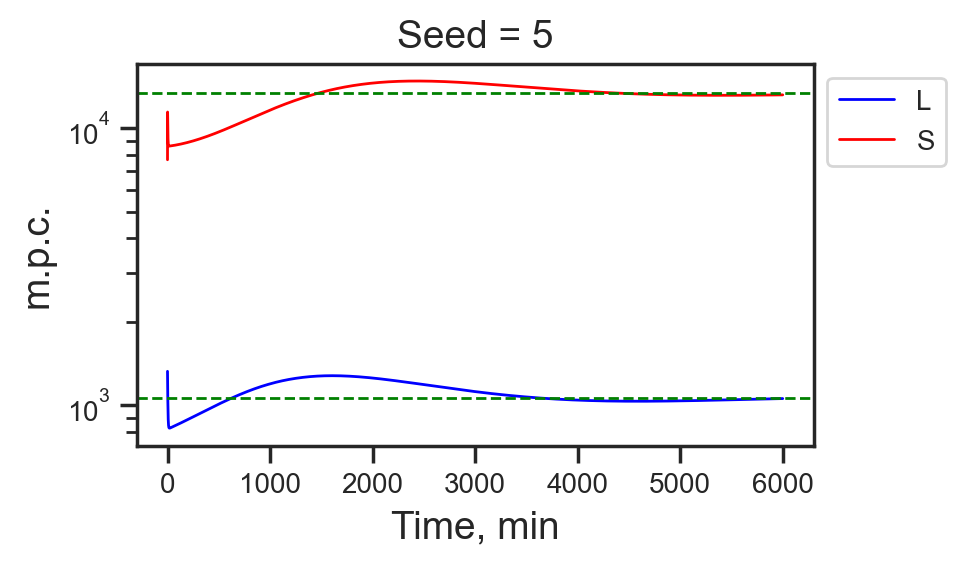

plot: 6


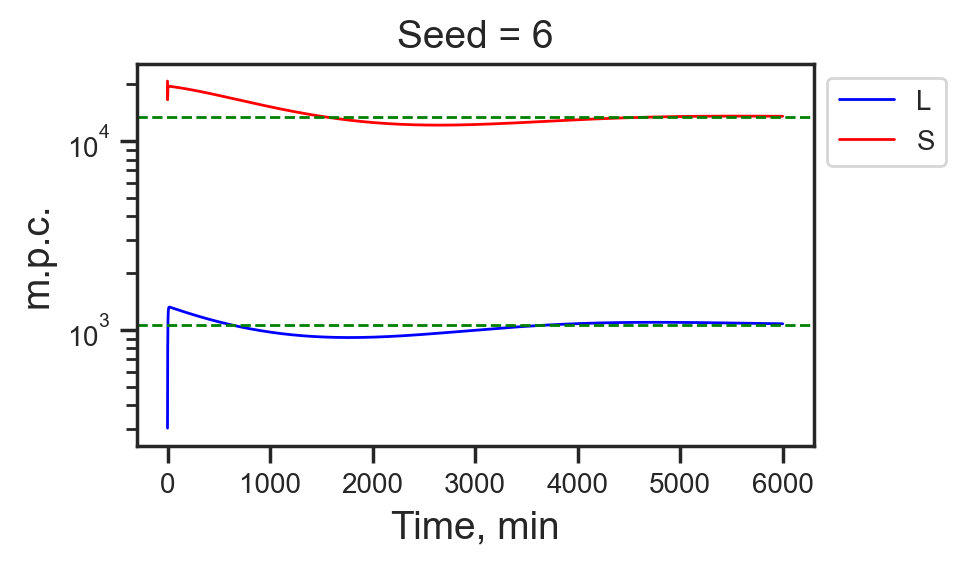

plot: 7


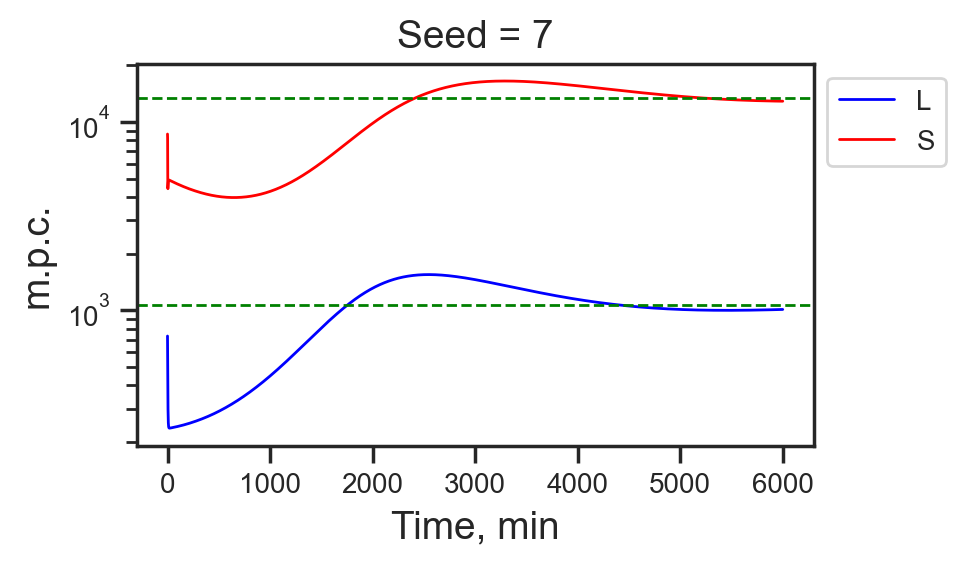

plot: 8


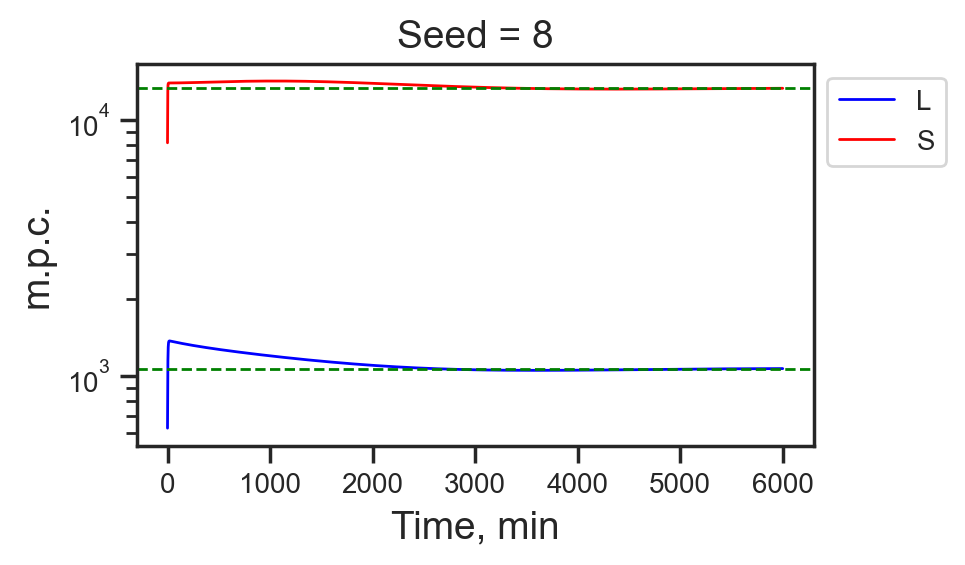

plot: 9


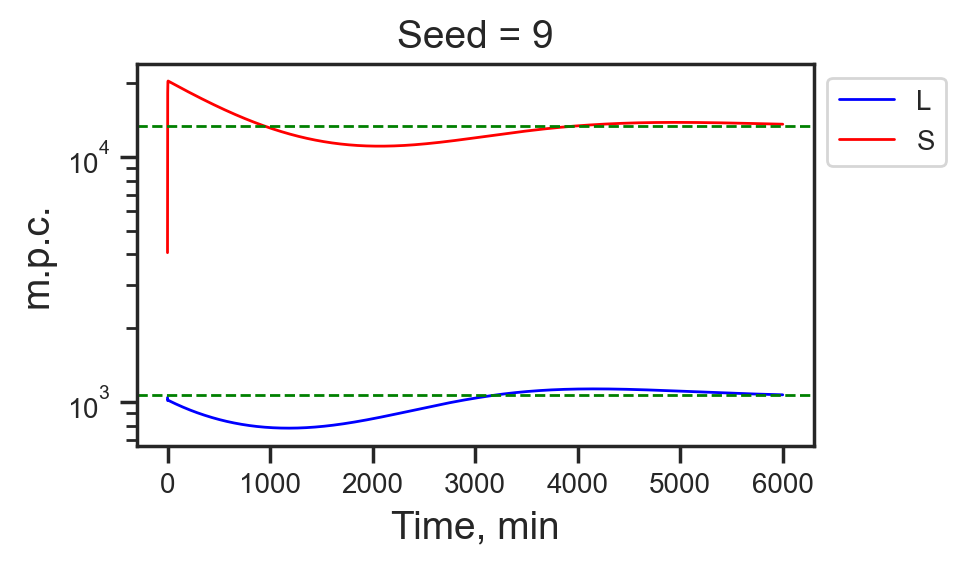

In [83]:
### Plot in loop ###
n = 6000 #int((t_finish-t_start)/step)

# plot L and S dynamics
for i,sol in enumerate(sols):
    
    # Plot
    print("plot:", i)
    fig, ax = plt.subplots(figsize=(5,3))
    
    for j in [-2,-1]:
        ax.plot(sol.t[:n], sol.y[j,:n], '-', color=colormap[j], label=var_keys[j])
        # plot stationary solution
        plt.axhline(root0.x[j], color='g', linestyle='--', lw=1)
        
    # Set axes
    ax.set_title(f'Seed = {i}', fontsize=14)
    ax.set_xlabel('Time, min')
    ax.set_ylabel('m.p.c.')
    ax.set_yscale('log')
    ax.axis('auto')
    ax.legend(bbox_to_anchor=[1.,1])
    plt.tight_layout()
    
    # save figure
    dir_pic_tmp = dir_pic+"mutual/"
    check_dir_exist(dir_pic_tmp)
    check_dir_exist(dir_pic_tmp+"svg/")
    fig_name = f"dyn_LS_seed_{i}"
    if save_pic: plt.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
    if save_svg: plt.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
    plt.show()

In [84]:
# some functions (round to some number)
def round_up(x, num):
    return int(ceil(x / num)) * num
    
def round_down(x, num):
    return int(floor(x / num)) * num

# Find max and min (LINE-1 and SINE)
maxL, minL = [], []
maxS, minS = [], []
for sol in sols:
    maxL0, minL0 = sol.y[-2,:].max(), sol.y[-2,:].min()
    maxS0, minS0 = sol.y[-1,:].max(), sol.y[-1,:].min()
    maxL.append(maxL0)
    minL.append(minL0)
    maxS.append(maxS0)
    minS.append(minS0)

# to numpy
maxL = np.array(maxL)
minL = np.array(minL)
maxS = np.array(maxS)
minS = np.array(minS)

# find max & min values
maxL0, minL0 = maxL.max(), minL.min()
maxS0, minS0 = maxS.max(), minS.min()
        
# Round_up
up2 = 100
maxL0 = round_up(maxL0, up2)
maxS0 = round_up(maxS0, up2)
# Round_down
minL0 = round_down(minL0, up2)
minS0 = round_down(minS0, up2)

# print
print("maxL =", maxL0)
print("minL =", minL0)
print("maxS =", maxS0)
print("minS =", minS0)

maxL = 1900
minL = 200
maxS = 20900
minS = 2700


plot: 0


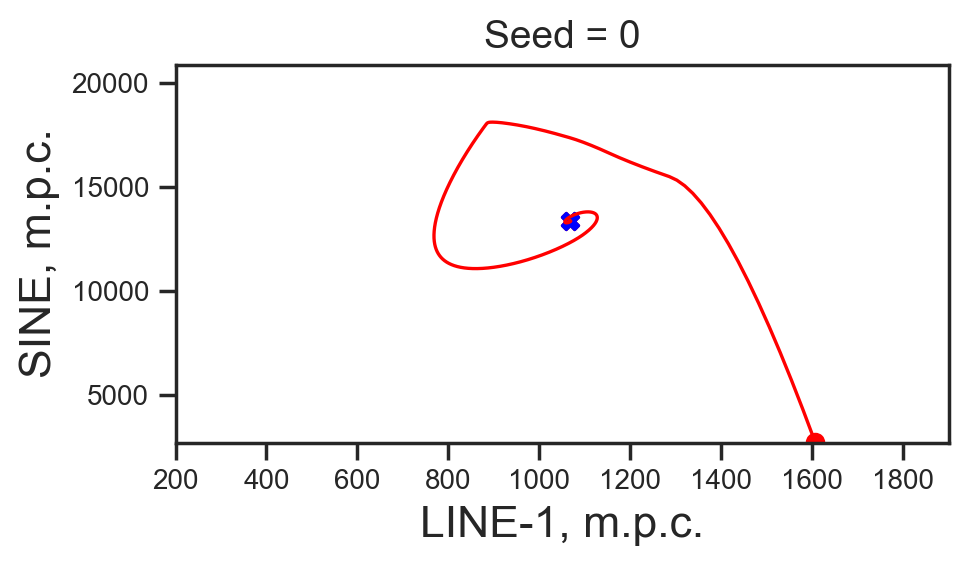

plot: 1


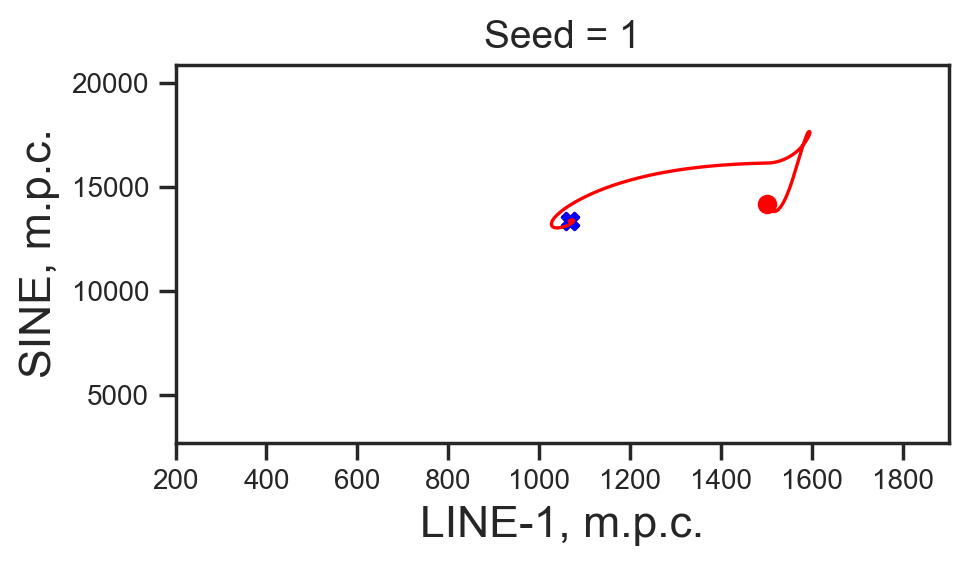

plot: 2


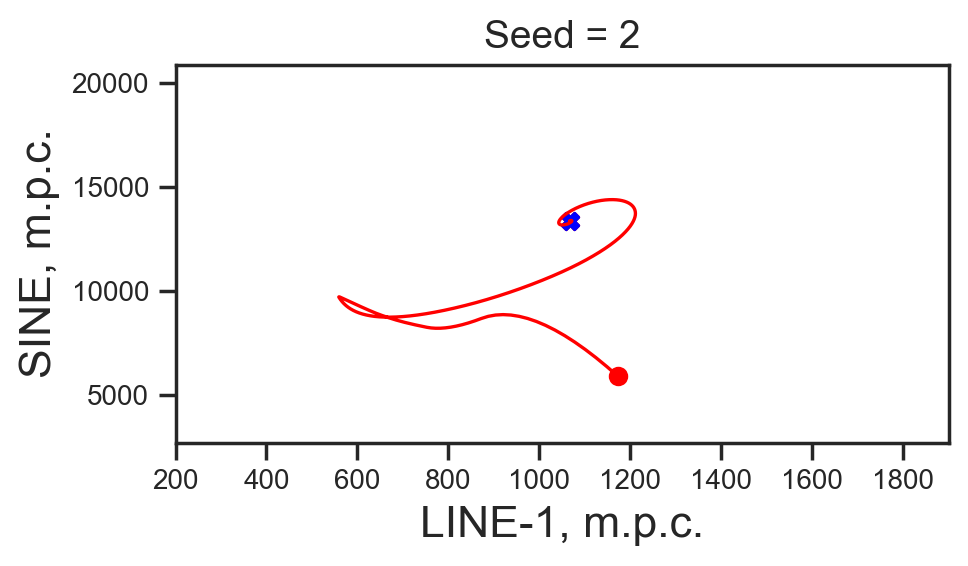

plot: 3


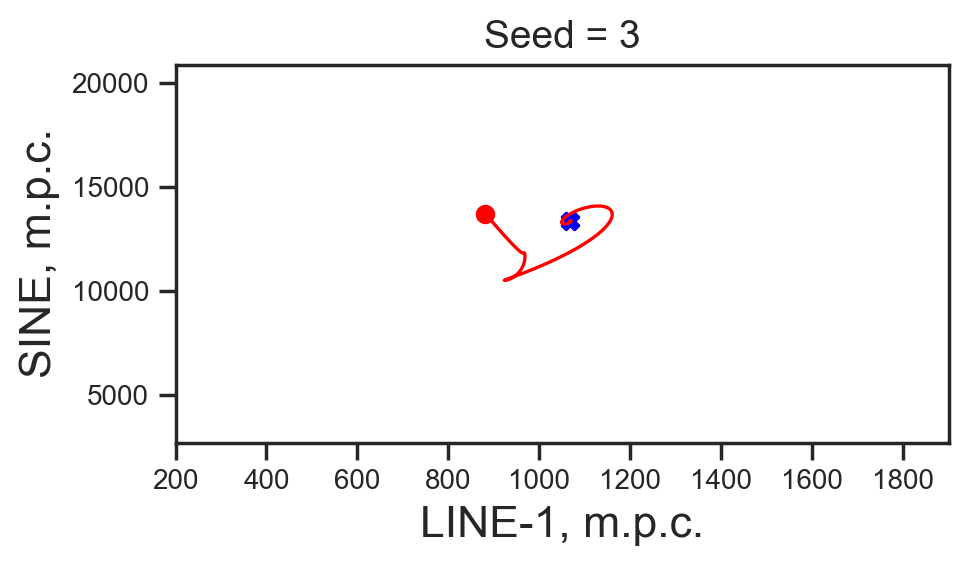

plot: 4


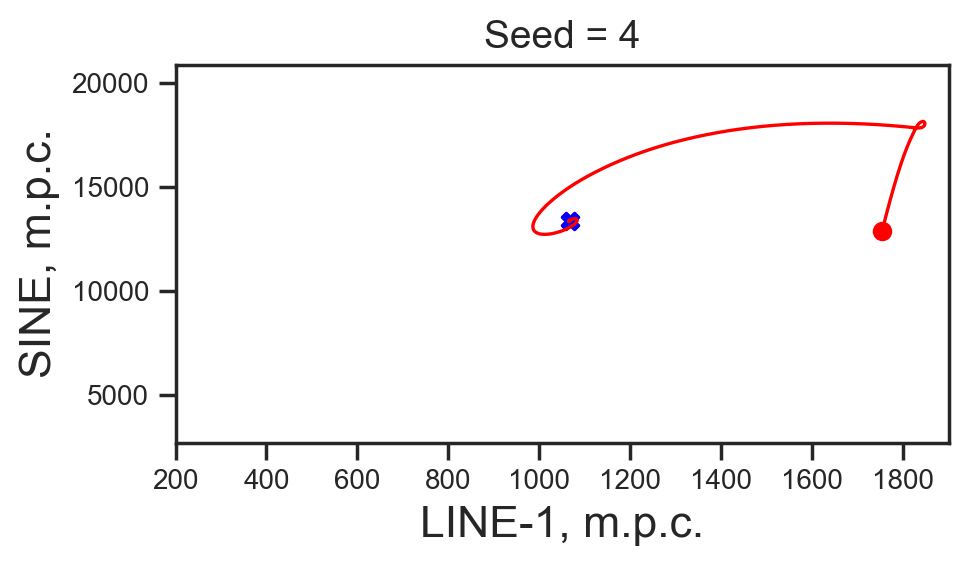

plot: 5


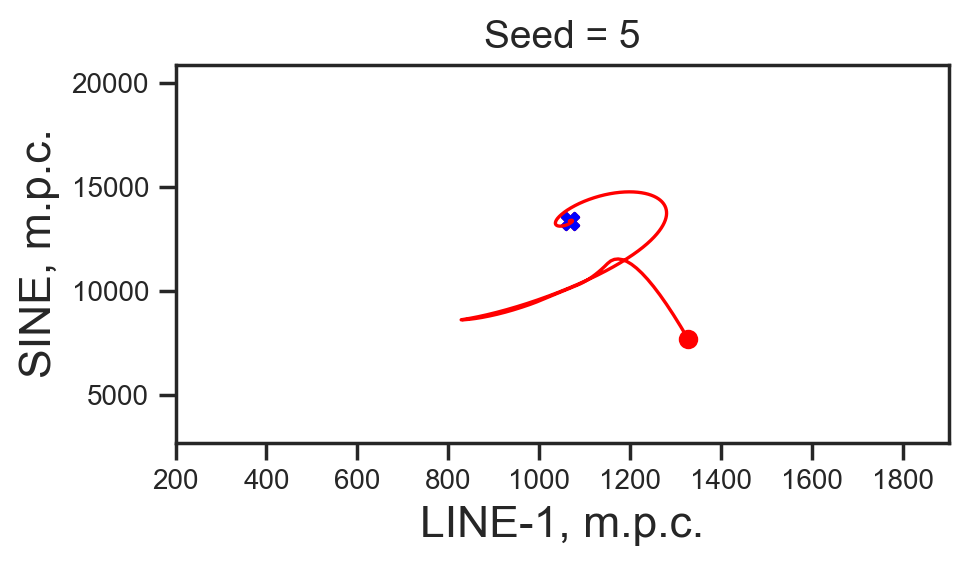

plot: 6


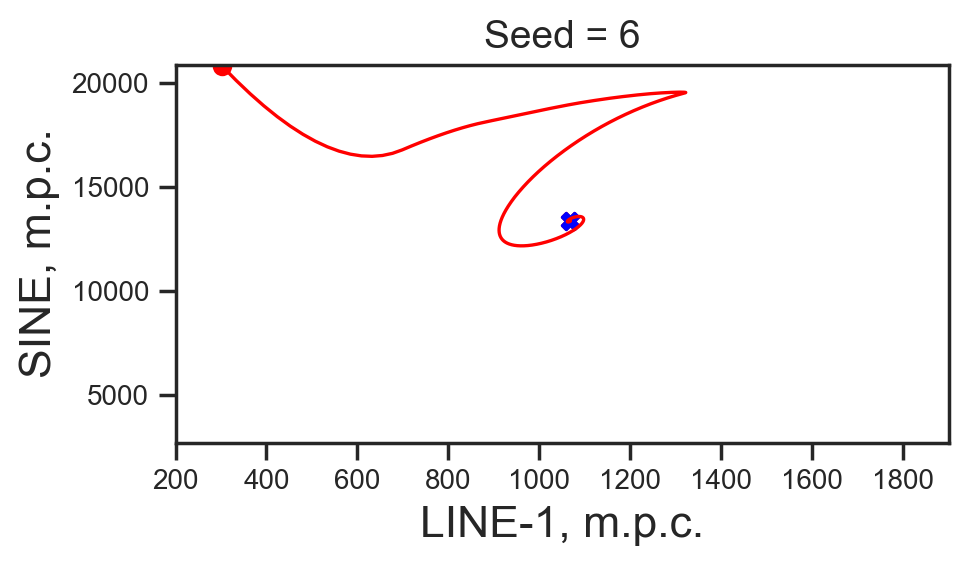

plot: 7


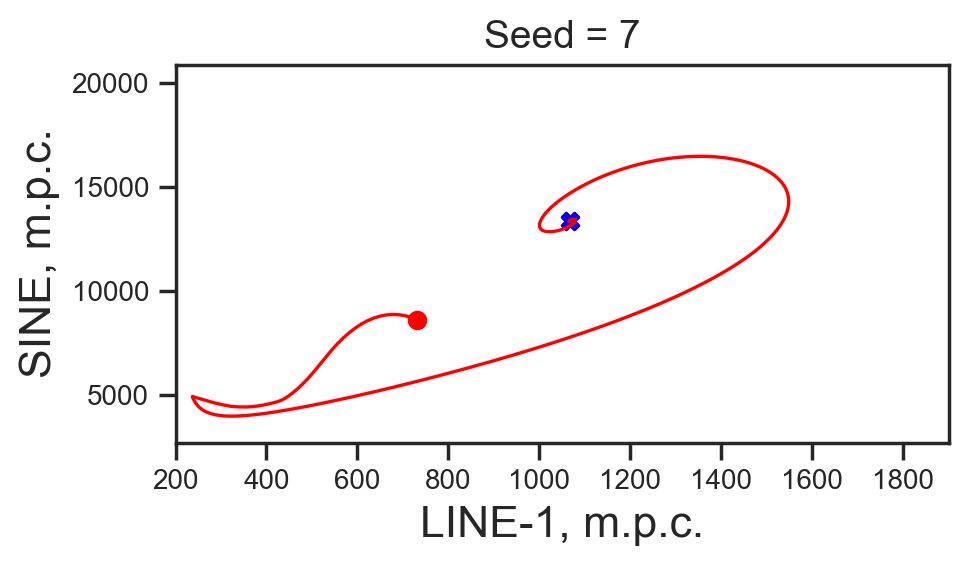

plot: 8


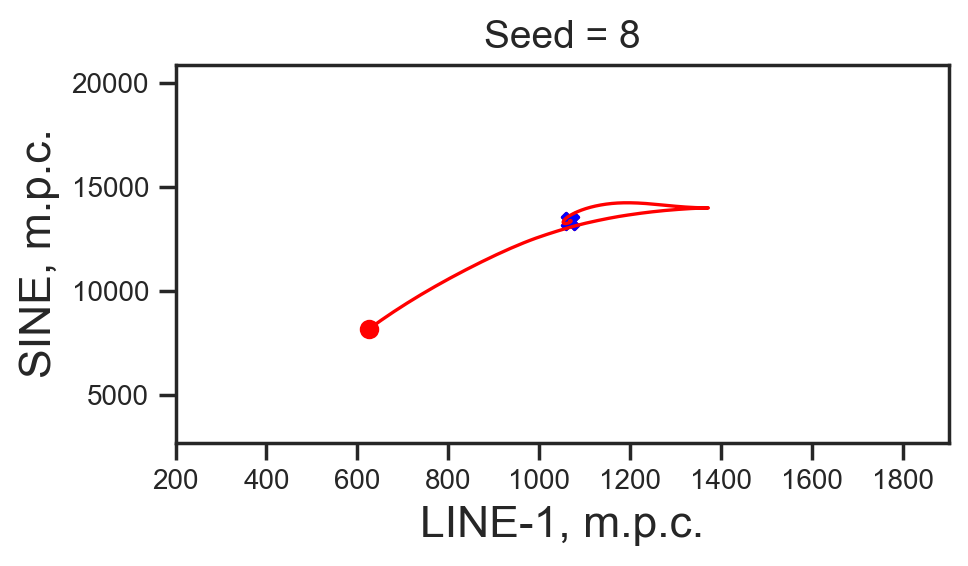

plot: 9


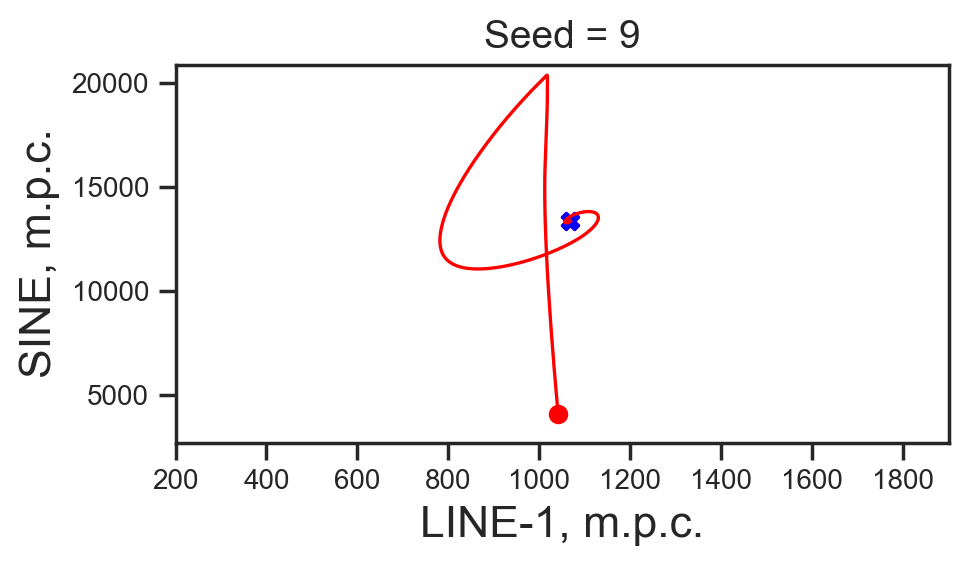

In [85]:
# Plot in loop
for i,sol in enumerate(sols):

    # Interpolate
    fL = interp1d(sol.t, sol.y[-2,:], kind='quadratic')
    times = np.arange(sol.t.min(), sol.t.max(), 0.1)
    yL = fL(times)
    fS = interp1d(sol.t, sol.y[-1,:], kind='quadratic')
    yS = fS(times)
    
    # PLot
    print("plot:", i)
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(yL, yS, '-', lw=1.2, color='red')
    ax.scatter(yL[0], yS[0], marker='o', color='red')
    ax.scatter(yL[-1], yS[-1], marker='X', color='red')
    ax.scatter(root0.x[-2], root0.x[-1], marker='X', color='blue')
    
    # Label axes
    ax.set_xlim(minL0, maxL0)
    ax.set_ylim(minS0, maxS0)
    # ax.set_xlim(round_down(minL[i], up2), round_up(maxL[i], up2))
    # ax.set_ylim(round_down(minS[i], up2), round_up(maxS[i], up2))
    ax.set_title(f'Seed = {i}')
    ax.set_xlabel('LINE-1, m.p.c.', fontsize=16)
    ax.set_ylabel('SINE, m.p.c.', fontsize=16)
    # ax.axis('auto')
    plt.tight_layout()
    
    # save figure
    dir_pic_tmp = dir_pic+"mutual/"
    check_dir_exist(dir_pic_tmp)
    check_dir_exist(dir_pic_tmp+"svg/")
    fig_name = f"mut_LS_seed_{i}"
    if save_pic: plt.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
    if save_svg: plt.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
    plt.show()